The process can be defined from ($\varphi, \lambda, Q$) where
* $\varphi$ is the ODE dynamics - or the integral path defined by a vector field $\Phi$
* $\lambda$ is the probability that a jumps occurs during the particle's movement
* $Q$ is the Markov kernel used for the jump

ZigZag sampler:

* $\Phi(x, v)$ = v
* $\lambda(x, v)_i = (v_i (\partial \psi(x))_i)_+$, with $\pi \propto \exp(-\psi(x))$ the target distribution. For Gaussian distribution: $$\lambda(x, v)_i = (v_i x_i)_+ $$
* Q reverses speed.

For the reverse process, we essentially just need to compute, for all $i$:
$$ \bar \lambda_i = \lambda_i \dfrac{p_t(x_t, R_i v_t)}{p_t(x_t, v_t)} $$
Notations:
$$ s_{\theta}(x, R v, t) = \begin{pmatrix} s_{\theta}(x, R_1 v, t)_1 \\ \cdots \\ s_{\theta}(x, R_d v, t)_d \end{pmatrix}$$
where $R_i v = \begin{pmatrix} v_1 \\ \cdot \\ -v_i \\ \cdot \\ v_n \end{pmatrix}$
* Fit the model by minimizing:
     $$ \mathbb{E}_{t, x, v} \|  s_{\theta}(x, v, t) - \dfrac{p_t(x_t, R v_t)}{p_t(x_t, v_t)}\|^2 =  \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t)$$



Current Limitations
* If the dimension is $d$, we need $d+1$ forward pass, because:
$$ \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t) = \mathbb{E}_{t, x, v} \sum_{i=1}^d \frac12 s_{\theta}(x, v, t)_i^2 - s_{\theta}(x, R_i v, t)_i$$
* The loss is unstable.

**Symmetrised ratio matching** we introduce the function $g(r) = \frac{1}{1+r}$ and define the objective function
\begin{equation}
    J_{ERM}(\theta) = \sum_{i=1}^d \mathbb{E}_{p_t}\left[ \left(g(s_\theta(X_t,V_t,t)[i]) - g(r_i(X_t,V_t,t)) \right)^2 + \left(g(s_\theta(X_t,R_iV_t,t)[i]) - g(r_i(X_t,R_iV_t,t)) \right)^2 \right]
\end{equation}
which is equivalent, as an objective function, to:
\begin{equation}
    J_{IRM}(\theta) = \sum_{i=1}^d \mathbb{E}_{p_t}\left[ \frac{1}{(1 + s_\theta(x,v,t)[i])^2} +\frac{1}{(1 + s_\theta(x,R_i v,t)[i])^2}  - \frac{2}{1 + s_\theta(x,v,t)[i]}\right]
\end{equation}


**KL minimisation** Focus on the score entropy:
\begin{equation}
    J_{ERM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] -r_i(X_t,V_t,t)  - \Big( \log s_\theta(X_t,R_iV_t,t)[i]) - \log r_i(X_t,R_iV_t,t)\Big) \right].
\end{equation}
where $\{w_i\}$ is a sequence of weights. Also this objective function considers the error in the estimation of both $r_i(x,v,t)$ and $r_i(x,R_iv,t)$, encouraging stable solutions. Clearly the implicit formulation has objective function 
\begin{equation}
    J_{IRM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] -  \log s_\theta(X_t,R_iV_t,t)[i]) \right].
\end{equation}

Question: shouldn't it be
\begin{equation}
    J_{IRM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] +  \log s_\theta(X_t,R_iV_t,t)[i]) \right] \quad ?
\end{equation}

TODO:
* Architecture. Change the network architecture. Receives $R$ as an argument, and is made invariant on speed?
    $$ s_{\theta}(x, v, R) : \quad  s_{\theta}(x, Rv, R) = s_{\theta}(x, v, R)$$ 
    Take the component $i$ as an input. Idea of copula? Take a single dimension as input too? outputs a single value.
* Dimension problem.
* Stable training.
* Mixing time of pdmp (time horizon?)
* Experiments: 
    * Other datasets. $\mathcal{N}(\mu, \sigma^2 I_2)$ instead of mixture. Increase dimensions.
    * Effect of the number of reverse steps. Effect of the reverse sampler
    

# PDMP

## Setup

* Model takes $(X_t, V_t)$ as input (4 in 2d). Outputs $\lambda_i$ for each i (2 in 2d)
* Some of the code is relying on dictionnaries to define constituting parameters

In [1]:
import numpy as np
import torch
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True,
    'dropout_rate' : .0,
    'nblocks' : 2,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',#'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, 
    'compute_gamma': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'gmm_2',
    'std' : 0.1, # 0.5, 0.05,
    'n_mixture' : 2, # must be square. set to None if not a grid mixture
    'normalize' : True,
    #'weights': np.array([1/2]*2),
    'weights': None,#[.01, .1, .3, 
               # .2, .02, .15,
               # .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'alpha': 2.,
    #'isotropic': True
}

device = 'mps'

* Prepare all our objects

In [2]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import initial_code.pdmp as pdmp
import Data as Data
import Generate as Gen
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt

# original data, get dataloader
gmm_2 = Data.Generator(**p_data_2d)#('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate()
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset(GMM2)#, torch.tensor([0.]).repeat(GMM2.shape[0]))
data = DataLoader(dataset, 
                batch_size=p_data_2d['nsamples'] // 8, 
                shuffle=True, 
                num_workers=1)

# model
model = LevyDiffusionModel({'data': {'nfeatures': p_data_2d['nfeatures']}, 'model':p_model_2d, 'device': 'cpu'}).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=1e-3, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = pdmp.PDMP(total_time = 8)

# Manager for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

0


## Look at the noised data

In [204]:
# clone data, since it will be modified by forward process
data_clone = GMM2.clone()
# orint its shape
print(data_clone.shape)
# get a unit time horizon
time_horizons = torch.ones(data_clone.shape) 
for i in range(int(pdmp.T)):
    t = time_horizons.clone()
    pdmp.forward(data_clone, t)
#* pdmp.T
# forward process for pmdp.T time units
#pdmp.forward(data_clone, time_horizons)

torch.Size([32768, 1, 2])


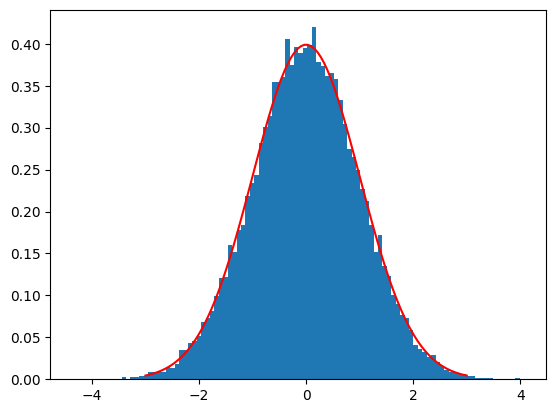

In [207]:
# look at histogram of one component at the last timestep

pos = data_clone.squeeze(1) # remove channel dimension
import scipy.stats as stats
X = np.linspace(-3, 3, 100)
Y = stats.norm.pdf(X, 0, 1)
plt.plot(X, Y, color='red')
plt.hist(pos[:, 0], bins='auto', density=True)
plt.show()

## Train the model

In [6]:
# can use this to load a model and optimizer

MODEL_PATH = 'models/first_model.pt'

chpt = torch.load(MODEL_PATH)
model.load_state_dict(chpt['model'])
optimizer.load_state_dict(chpt['optimizer'])

In [17]:
# actually training the model

from tqdm import tqdm
import torch.nn as nn

# potential gradient clipping
grad_clip = None

# training
model.train()
for i in tqdm(range(20)):
    epoch_loss = steps = 0
    for i, (Xbatch,) in enumerate(data):
        # training loss

        # generate random speed
        Vbatch = torch.tensor([-1., 1.])[torch.randint(0, 2, (2*Xbatch.shape[0],))]
        Vbatch = Vbatch.reshape(Xbatch.shape[0], 1, 2)

        # generate random time horizons
        time_horizons = pdmp.T * (torch.rand(Xbatch.shape[0])**2)

        # must be of the same shape as Xbatch for the pdmp forward process, since it will be applied component wise
        t = time_horizons.clone().detach().unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 2)
        
        # clone our initial data, since it will be modified by forward process
        x = Xbatch.clone()
        v = Vbatch.clone()
        
        # apply the forward process
        pdmp.forward(Xbatch, t, Vbatch)
        
        # check that the data has been modified
        assert ((x != Xbatch).any()) and ((v != Vbatch).any())
        # check that the time horizon has been reached for all data
        assert not (t != 0.).any()
        
        # send to device
        Xbatch = Xbatch.to(device)
        Vbatch = Vbatch.to(device)
        time_horizons = time_horizons.to(device)
        
        # tensor to give as input to the model. It is the concatenation of the position and the speed.
        X_V_t = torch.concat((Xbatch, Vbatch), dim = -1)
        #print(time_horizons[0], X_V_t[0])
        #print(X_V_t.mean(dim = 0), X_V_t.std(dim = 0))

        # run the model
        output = model(X_V_t, time_horizons)

        # invert time on component 1 and 2
        X_V_inv_t_1 = X_V_t.detach().clone() # clone to avoid modifying the original tensor, detach to avoid computing gradients on original tensor
        X_V_inv_t_2 = X_V_t.detach().clone()
        X_V_inv_t_1[:, :, 2] *= -1 # reverse speed on i = 1
        X_V_inv_t_2[:, :, 3] *= -1 # reverse speed on i = 2

        # run the model on each inverted speed component
        output_inv_1 = model(X_V_inv_t_1, time_horizons)
        output_inv_2 = model(X_V_inv_t_2, time_horizons)
        
        # compute the loss
        def g(x):
            return (1 / (1+x))
        loss = g(output[:, :, 0])**2 + g(output_inv_1[:, :, 0])**2
        loss += g(output[:, :, 1])**2 + g(output_inv_2[:, :, 1])**2
        loss -= 2*(g(output[:, :, 0]) + g(output[:, :, 1]))
        loss = loss.mean()
        #speed_idx_0 = X_V_t[:, :, 2] + 1 //2 # 0 if speed_0 is -1, 1 if speed_0 is 1
        #speed_idx_1 = X_V_t[:, :, 3] + 1 //2 # 0 if speed_1 is -1, 1 if speed_1 is 1
        #loss = 0.5*output[:, :, 0]**2 - (1 / output[:,:,0])
        #loss += 0.5*output[:, :, 1]**2 - (1 / output[:,:,1])
        #loss = loss.mean()
        #normalize_mean = output.mean()
        #loss += (torch.log(normalize_mean))**2
        #loss  = (1 / (1 + output.mean()) - 1 / 2)**2
        #loss += - torch.log(output_inv_1).mean() - torch.log(output_inv_2).mean()
        #if i % 10 != 0:
        #    loss = 0.5*output[:, :, 0]**2 - (output_inv_1[:,:,0])
        #    loss += 0.5*output[:, :, 1]**2 - (output_inv_2[:,:,1])
        #    loss = loss.mean()
        #loss = 0.5*output[:, :, 0]**2 - (output[:,:,2 + 0])
        #loss += 0.5*output[:, :, 1]**2 - (output[:,:,2 + 1])
        #else:
        #    loss = .5*((1 / output[:,:,0]).mean() - 1)**2
        #    loss += .5*((1 / output[:,:,1]).mean() - 1)**2
        #    loss += .5*((output_inv_1[:,:,0]).mean() - 1)**2
        #    loss += .5*((output_inv_2[:,:,1]).mean() - 1)**2
        #    loss += .5*((output[:, :, 0] * output_inv_1[:,:,0] - 1).mean())**2
        #    loss += .5*((output[:, :, 1] * output_inv_2[:,:,1] - 1).mean())**2
        #    loss = loss.mean()
        #loss += (output.mean() - 1)**2
        #loss += (output_inv_1.mean() - 1)**2
        #loss += (output_inv_2.mean() - 1)**2
        #loss += (output[:, :, 0] * output_inv_1[:,:,0] - 1).mean()
        #loss += (output[:, :, 1] * output_inv_2[:,:,1] - 1).mean()
        # and finally gradient descent
        optimizer.zero_grad()
        loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        # add to epoch loss
        epoch_loss += loss.item()
        steps+= 1
    # compute epoch loss
    epoch_loss = epoch_loss / steps
    print('epoch_loss :{}'.format(epoch_loss))

  5%|██████▎                                                                                                                       | 1/20 [00:01<00:33,  1.78s/it]

epoch_loss :-1.2022376358509064


 10%|████████████▌                                                                                                                 | 2/20 [00:03<00:32,  1.78s/it]

epoch_loss :-1.2042168080806732


 15%|██████████████████▉                                                                                                           | 3/20 [00:05<00:30,  1.77s/it]

epoch_loss :-1.2053498476743698


 20%|█████████████████████████▏                                                                                                    | 4/20 [00:07<00:27,  1.74s/it]

epoch_loss :-1.209599494934082


 25%|███████████████████████████████▌                                                                                              | 5/20 [00:08<00:26,  1.76s/it]

epoch_loss :-1.2101198732852936


 30%|█████████████████████████████████████▊                                                                                        | 6/20 [00:10<00:24,  1.76s/it]

epoch_loss :-1.208668738603592


 35%|████████████████████████████████████████████                                                                                  | 7/20 [00:12<00:23,  1.84s/it]

epoch_loss :-1.2132030874490738


 40%|██████████████████████████████████████████████████▍                                                                           | 8/20 [00:14<00:22,  1.86s/it]

epoch_loss :-1.2140081971883774


 45%|████████████████████████████████████████████████████████▋                                                                     | 9/20 [00:16<00:20,  1.89s/it]

epoch_loss :-1.2099100649356842


 50%|██████████████████████████████████████████████████████████████▌                                                              | 10/20 [00:18<00:19,  1.96s/it]

epoch_loss :-1.2142455726861954


 55%|████████████████████████████████████████████████████████████████████▊                                                        | 11/20 [00:20<00:17,  1.98s/it]

epoch_loss :-1.2188041359186172


 60%|███████████████████████████████████████████████████████████████████████████                                                  | 12/20 [00:22<00:15,  1.98s/it]

epoch_loss :-1.2133647203445435


 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 13/20 [00:24<00:14,  2.01s/it]

epoch_loss :-1.2159157991409302


 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 14/20 [00:26<00:11,  1.98s/it]

epoch_loss :-1.2184994369745255


 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 15/20 [00:28<00:09,  2.00s/it]

epoch_loss :-1.2159811705350876


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 16/20 [00:30<00:07,  1.98s/it]

epoch_loss :-1.2184363156557083


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 17/20 [00:32<00:05,  1.98s/it]

epoch_loss :-1.22108094394207


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 18/20 [00:34<00:03,  1.99s/it]

epoch_loss :-1.2178387939929962


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 19/20 [00:36<00:02,  2.00s/it]

epoch_loss :-1.2221268564462662


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.93s/it]

epoch_loss :-1.2247208505868912


In [18]:
# save the model
MODEL_PATH = 'models/first_model.pt'

checkpoint = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(checkpoint, MODEL_PATH)

# Reverse Sampling

## Reverse process

In [19]:
# generate data
## For the backward process
def flip_given_rate(v, lambdas, s):
    lambdas[lambdas == 0.] += 1e-9
    event_time = torch.distributions.exponential.Exponential(lambdas)
    v[event_time.sample() <= s] *= -1.

def splitting_zzs_DBD(model, T, N, nsamples = None, x_init=None, v_init=None):
    timesteps = torch.linspace(1, 0, N+1)**2 * T
    #timesteps = timesteps.flip(dims = (0,))
    #times = T - deltas.cumsum(dim = 0)
    assert (nsamples is not None) or (x_init is not None) or (v_init is not None) 
    if x_init is None:
        x_init = torch.randn(nsamples, 1, 2)
    if v_init is None:
        v_init = torch.tensor([-1., 1.])[torch.randint(0, 2, (x_init.shape[0],))].reshape(x_init.shape[0], 1, 1).repeat(1, *(x_init.shape[1:]))
    #chain = [pdmp.Skeleton(torch.clone(x_init), torch.clone(v_init), 0.)]
    chain = []
    x = x_init.clone()
    v = v_init.clone()
    model.eval()
    #print(x)
    with torch.inference_mode():
        for i in range(int(N)):
            time = timesteps[i]
            delta = (timesteps[i] - timesteps[i+1]) if i < N - 1 else timesteps[i]
            chain.append(torch.concat((x, v), dim = -1))
            # compute x_n-1 from x_n
            x = x - v * delta / 2 # x - v * δ / 2
            time_mid = time - delta/ 2 #float(n * δ - δ / 2) #float(n - δ / 2)
            density_ratio = model(torch.concat((x,v), dim = -1).to(device),
                                  (torch.ones(x.shape[0])*time_mid).to(device))[:, :, :2]
            print(density_ratio.mean(dim=0))
            #print(density_ratio)
            #print(grad_x)
            switch_rate = density_ratio.cpu()* torch.maximum(torch.zeros(x.shape), -v * x)
            #print(switch_rate)
            #print(switch_rate[switch_rate <= 0.])
            flip_given_rate(v, switch_rate, delta)
            x = x - v * delta / 2 #x - v * δ / 2
            #print(x, v)
            #chain.append(Skeleton(x.copy(), v.copy(), n * δ))
    chain.append(torch.concat((x, v), dim = -1))
    return chain


## Generate data

In [20]:
# generate the reverse chain
#delta = 1e-1
chain = torch.stack(splitting_zzs_DBD(model, pdmp.T, 250, nsamples = 1000))

tensor([[0.9547, 0.9955]], device='mps:0')
tensor([[0.9550, 0.9953]], device='mps:0')
tensor([[0.9546, 0.9944]], device='mps:0')
tensor([[0.9544, 0.9934]], device='mps:0')
tensor([[0.9545, 0.9927]], device='mps:0')
tensor([[0.9544, 0.9917]], device='mps:0')
tensor([[0.9559, 0.9914]], device='mps:0')
tensor([[0.9558, 0.9907]], device='mps:0')
tensor([[0.9558, 0.9897]], device='mps:0')
tensor([[0.9581, 0.9889]], device='mps:0')
tensor([[0.9590, 0.9885]], device='mps:0')
tensor([[0.9596, 0.9883]], device='mps:0')
tensor([[0.9608, 0.9878]], device='mps:0')
tensor([[0.9617, 0.9877]], device='mps:0')
tensor([[0.9637, 0.9874]], device='mps:0')
tensor([[0.9653, 0.9875]], device='mps:0')
tensor([[0.9662, 0.9871]], device='mps:0')
tensor([[0.9673, 0.9871]], device='mps:0')
tensor([[0.9678, 0.9869]], device='mps:0')
tensor([[0.9681, 0.9868]], device='mps:0')
tensor([[0.9690, 0.9866]], device='mps:0')
tensor([[0.9691, 0.9867]], device='mps:0')
tensor([[0.9694, 0.9862]], device='mps:0')
tensor([[0.

## Inspect generated data trajectory - from noise to data distribution

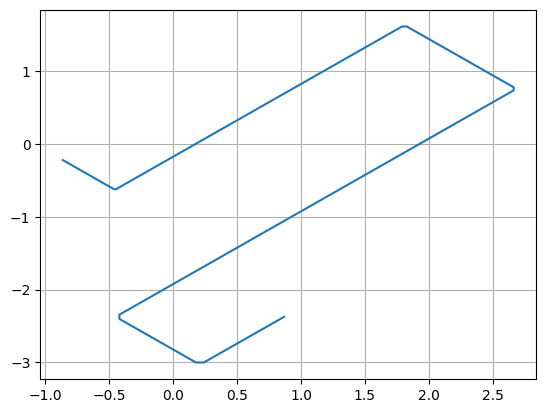

In [21]:
# Look at the position of the particle through time
pos = chain[:, 0, :, :2].squeeze(-2) # squeeze: remove channel dimension
plt.plot(pos[:, 0], pos[:, 1], linestyle='-')
plt.grid(True)
plt.show()

We can now use our GenerationManager object to examine the generated data.

* get animation

'./animation/check.mp4'

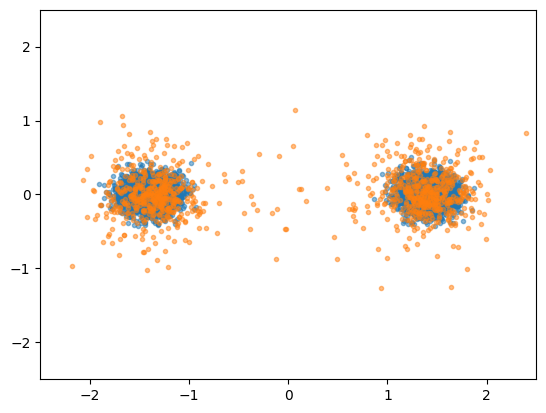

In [23]:
# Use Generation manager object to generate animation from the history of the data
gen_model.history = chain[:, :, :, :2]
gen_model.animation(generated_data_name = 'check')

* Get plot of the generated data.

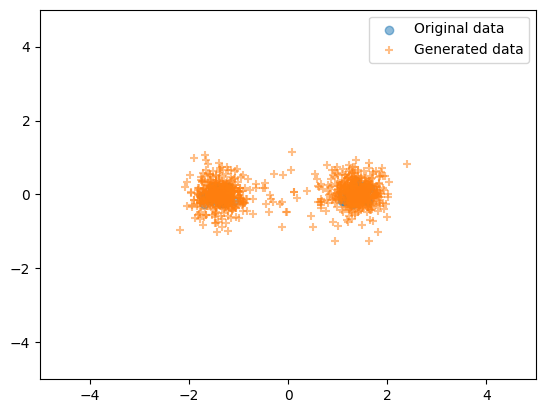

In [22]:
lims = 5
gen_model.samples = chain[-1, :, :, :2].squeeze(-2) # get the last position of every sample, remove channel dimension
gen_model.get_plot(limit_nb_orig_data = 100, # number of original data to plot
                   xlim = (-lims, lims), ylim = (-lims, lims))